В этом ноутбуке находится код для обучения модели по распознаванию комнат.

# Проводим подготовку

In [1]:
%%capture
!pip install datasets transformers

Импортируем все необходимые библиотеки.

In [2]:
import os
import numpy as np
from copy import deepcopy
from transformers import ViTImageProcessor, ViTModel
from datasets import Dataset, DatasetDict, load_dataset
import torch
from tqdm.notebook import tqdm
import torch.nn.functional as f

import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

In [4]:
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

И загружаем датасет. Для удобства мы предрасчитали эмбеддинги для каждого кадра на видео и вместе с классами сложили в датасет, который хранится на Huggingface.

In [5]:
dds = load_dataset("ummagumm-a/frames_room_cls")
train_ds = dds['train']
test_ds = dds['test']

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3276 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/459 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ummagumm-a___parquet/ummagumm-a--frames_room_cls-28df2baab8cf95b0/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Создаём датасеты

In [6]:
class FrameDataset(torch.utils.data.Dataset):
    """
    Этот класс отвечает за выгрузку данных, 
    сформированных в последовательности кадров из видео.

    :param ds: HuggingFace датасет, трейн или тест. Должен содержать колонки
               `video_id`, `video_name`, `data` и `label`.
               Для примера смотреть `ummagumm-a/frames_room_cls
    :param label_encoder: fitted LabelEncoder. Будет преобразовывать
               текстовые лейблы в индексы классов.
    :param num_classes: количество классов.
    :param smoothing: размер окна сглаживания, которое будет применяться к разметке.
               требуется, чтобы позволить модели быть неуверенной на сложных участках,
               а именно на переходах между разными комнатами. Советуем использовать значение 3.

    """
    def __init__(self, ds: Dataset, label_encoder: LabelEncoder, 
                 num_classes=6, smoothing=None):
        
        super().__init__()
        self.video_ids = np.array(ds['video_id'])
        self.video_names = np.array(ds['video_name'])
        self.data = np.array(ds['data'])
        self.label = label_encoder.transform(np.array(ds['label']))
        self.num_classes = num_classes
        self.smoothing = smoothing

    def __len__(self):
        return len(np.unique(self.video_ids))

    def __getitem__(self, idx: int):
        indices = np.where(self.video_ids == idx)[0]
        # detected objects
        pkl_path = os.path.join('pickles', self.video_names[indices[0]] + '.pkl')
        detobjs = pickle.load(open(pkl_path, 'rb'))
        detobjs = torch.tensor(np.array([x for _, x in detobjs[::10]]))
        # image embeddings
        x = self.data[indices]
        x = torch.tensor(x)
        # merge embeddings and detected objects
        x = torch.hstack((x, detobjs)).float()
        # prepare labels
        y = self.label[indices]
        y = torch.tensor(y)
        y = torch.nn.functional.one_hot(y, self.num_classes)
        y = y.float()
        # apply smoothing if required
        if self.smoothing:
            y = torchaudio.functional.convolve(y.T, 
                                               torch.ones((1, self.smoothing)) / self.smoothing, 
                                               mode='same').T

        return x, y

In [37]:
def get_dataloaders(train_ds, test_ds, smoothing=3, 
                    dimensionality_reduction=.99):
    """
    Эта функция уменьшает размерность эмбеддингов каждого из кадров,
    создаёт датасеты и засовывает их в DataLoader.

    :param train_ds: тренировочный датасет.
    :param test_ds: тестовый датасет.
    :param smoothing: размер окна сглаживания.
    :param dimnsionality_reduction: amount of variance that needs to be explained.
                                    см. документацию к PCA из sklearn.
    """

    if dimensionality_reduction:
        train_d = np.array(train_ds['data'])
        test_d = np.array(test_ds['data'])

        # fit a normalizer
        ss = StandardScaler()
        ss = ss.fit(train_d)

        # fit PCA
        pca = PCA(n_components=dimensionality_reduction)
        pca = pca.fit(ss.transform(train_d))

        # Instantiate new datasets with reduced number of dimenstions in data.
        train_ds = Dataset.from_dict({"data": pca.transform(ss.transform(train_d)),
                                      "label": train_ds["label"],
                                      "video_id": train_ds["video_id"],
                                      "video_name": train_ds["video_name"]})
        
        test_ds = Dataset.from_dict({"data": pca.transform(ss.transform(test_d)),
                                     "label": test_ds["label"],
                                     "video_id": test_ds["video_id"],
                                     "video_name": test_ds["video_name"]})

    # numerical encoding for classes
    label_encoder = LabelEncoder().fit(train_ds['label'])
    # Instantiate the datasets
    ftrain_ds = FrameDataset(train_ds, label_encoder, smoothing=smoothing)
    ftest_ds = FrameDataset(test_ds, label_encoder)
    # Create dataloaders
    train_loader = data.DataLoader(ftrain_ds, shuffle=True)
    test_loader = data.DataLoader(ftest_ds)

    return train_loader, test_loader, label_encoder.classes_

In [38]:
train_loader, test_loader, class_names = get_dataloaders(train_ds, test_ds, smoothing=3)

`pickles.zip` может бы найдет [тут](https://drive.google.com/file/d/15YENNsQmUWEOUTrtsO45qGr5L5rxfKeZ/view?usp=share_link)

In [9]:
!unzip pickles.zip

Archive:  pickles.zip
  inflating: pickles/1.mp4.pkl       
  inflating: pickles/1-small.mp4.pkl  
  inflating: pickles/2.mp4.pkl       
  inflating: pickles/2023-02-14 15-03-46.MP4.pkl  
  inflating: pickles/2023-04-19 09-56-23.MP4.pkl  
  inflating: pickles/2023-05-10 14-44-10.MP4.pkl  
  inflating: pickles/3_Trim.mp4.pkl  
  inflating: pickles/4.mp4.pkl       
  inflating: pickles/5.mp4.pkl       
  inflating: pickles/6.mp4.pkl       
  inflating: pickles/7.MP4.pkl       
  inflating: pickles/IMG_9920.MOV.pkl  
  inflating: pickles/IMG_9921.MOV.pkl  
  inflating: pickles/IMG_9922.MOV.pkl  
  inflating: pickles/IMG_9923.MOV.pkl  
  inflating: pickles/IMG_9924.MOV.pkl  
  inflating: pickles/result.mp4.pkl  


In [10]:
for x, y in train_loader:
    print(x.shape, y.shape)
    # break

torch.Size([1, 39, 371]) torch.Size([1, 39, 6])
torch.Size([1, 968, 371]) torch.Size([1, 968, 6])
torch.Size([1, 116, 371]) torch.Size([1, 116, 6])
torch.Size([1, 60, 371]) torch.Size([1, 60, 6])
torch.Size([1, 203, 371]) torch.Size([1, 203, 6])
torch.Size([1, 37, 371]) torch.Size([1, 37, 6])
torch.Size([1, 41, 371]) torch.Size([1, 41, 6])
torch.Size([1, 23, 371]) torch.Size([1, 23, 6])
torch.Size([1, 464, 371]) torch.Size([1, 464, 6])
torch.Size([1, 366, 371]) torch.Size([1, 366, 6])
torch.Size([1, 247, 371]) torch.Size([1, 247, 6])
torch.Size([1, 712, 371]) torch.Size([1, 712, 6])


Ниже пример работы smoothing. На границах комнат, где точка перехода не всегда очевидна, мы позволяем модели быть неуверенной.

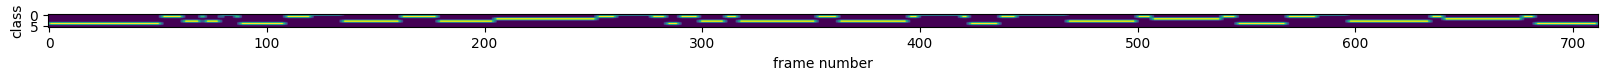

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(y[0].numpy().T)
plt.xlabel('frame number')
plt.ylabel('class')
plt.show()

Класс-классификатор. Мы использовали рекуррентнутю нейронную сеть GRU для вычисления признаков, зависящих от времени и последовательности. Затем, обычный линейный слой применяем для классификации. Из-за малого размера обучающей выборки есть опасность переобучения, поэтому мы используем Droupout для регуляризации.

In [19]:
class AirModel(nn.Module):
    def __init__(self, input_dim=371, hidden_dim=50, 
                 num_layers=1, num_classes=6, 
                 dropout_p=0.1):
        super().__init__()
        self.lstm = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, 
                           num_layers=num_layers, batch_first=True, 
                           bidirectional=True)
        self.linear = nn.Linear(2*hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.linear(x)
        
        return x

Эти классы созданы для того, чтобы загрузить модель в репозиторий Huggingface, и в них ничего интересного нет. Просто обёртки.

In [20]:
import torch.nn as nn
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig

class AirConfig(PretrainedConfig):
    model_type = 'gru'
    def __init__(self, input_dim=371, hidden_dim=50, num_layers=1, 
                 num_classes=6, dropout_p=0.01, device='cpu', **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.dropout_p = dropout_p
        self.device = device

class AirModelHF(PreTrainedModel):
    config_class = AirConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = AirModel(input_dim=self.config.input_dim, 
                              hidden_dim=self.config.hidden_dim, 
                              num_layers=self.config.num_layers,
                              num_classes=self.config.num_classes,
                              dropout_p=self.config.dropout_p)\
                              .to(self.config.device)

    def forward(self, input):
        return self.model(input) 

In [21]:
def eval(model, loss_fn, loader):
    """
    Эта функция отвечает за оценку модели на переданном датасете.

    :param model: модель.
    :param loss_fn: лосс функция, которая используется при обучении.
    :param loader: загрузчик данных.

    :returns: расчитанный лосс, реальные и предсказанные классы кадров
    """

    model.eval()
    with torch.no_grad():
        preds = []
        reals = []

        # for each batch
        for X_batch, y_batch in loader:
            # put tensors to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # run inference
            pred = model(X_batch)

            # save the results
            preds.append(pred[0])
            reals.append(y_batch[0])

        # Put data into a single tensor
        preds = torch.cat(preds)
        reals = torch.cat(reals)
        # Calculate the loss
        loss = loss_fn(preds, reals)

    return loss, reals, preds

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define model, loss function, optimizer and other necessary variables.
config = AirConfig(device=device, dropout_p=0.3)
model = AirModelHF(config)
best_model = None
best_loss = 1000
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

n_epochs = 100
for epoch in tqdm(range(n_epochs)):
    model.train()
    loss = 0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        # put batches on device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # get predictions
        y_pred = model(X_batch)
        # Gradient Accumulation, i.e. perform backward step only once in 4 steps
        # This is done because currently the dataloader returns a batch with a single element.
        # This is not efficient for optimization because the gradients are very noisy.
        # By performing Gradient Accumulation we make the effective batch size equal to 4.
        # .
        # why not setting a greater batch size in the dataloader?
        # the sequences have different lengths, so they cannot be put into a single batch easily.
        # and we don't want to use padding.
        loss += loss_fn(y_pred[0], y_batch[0])
        if (i + 1) % 4 == 0:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss = 0

    # Validation, do every 5 epochs
    if epoch % 5 != 0:
        continue
    
    # Obtain evaluation results for each dataset
    train_loss, train_real, train_pred = eval(model, loss_fn, train_loader)
    test_loss, test_real, test_pred = eval(model, loss_fn, test_loader)
    
    # Early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = deepcopy(model)
    print("Epoch %d: train loss %.4f, test loss %.4f" % (epoch, train_loss, test_loss))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: train loss 1.7463, test loss 1.7160
Epoch 5: train loss 1.3983, test loss 1.4201
Epoch 10: train loss 1.1638, test loss 1.2373
Epoch 15: train loss 0.9709, test loss 1.1011
Epoch 20: train loss 0.8026, test loss 0.9918
Epoch 25: train loss 0.6560, test loss 0.9044
Epoch 30: train loss 0.5334, test loss 0.8356
Epoch 35: train loss 0.4323, test loss 0.7807
Epoch 40: train loss 0.3493, test loss 0.7299
Epoch 45: train loss 0.2871, test loss 0.6882
Epoch 50: train loss 0.2404, test loss 0.6512
Epoch 55: train loss 0.2080, test loss 0.6252
Epoch 60: train loss 0.1857, test loss 0.6083
Epoch 65: train loss 0.1698, test loss 0.5934
Epoch 70: train loss 0.1580, test loss 0.5885
Epoch 75: train loss 0.1488, test loss 0.5792
Epoch 80: train loss 0.1420, test loss 0.5789
Epoch 85: train loss 0.1368, test loss 0.5761
Epoch 90: train loss 0.1324, test loss 0.5714
Epoch 95: train loss 0.1291, test loss 0.5747


Реальная разметка

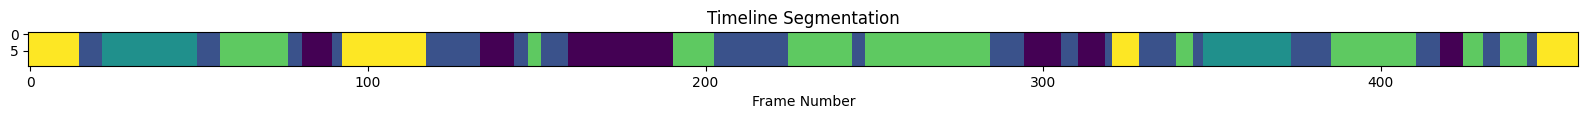

In [43]:
treal = test_real.argmax(axis=1).tolist()
plt.figure(figsize=(20,20))
plt.imshow(np.tile(treal, (10, 1)))
plt.xlabel('Frame Number')
plt.title('Timeline Segmentation')
plt.show()

Предсказанные классы для каждого кадра.

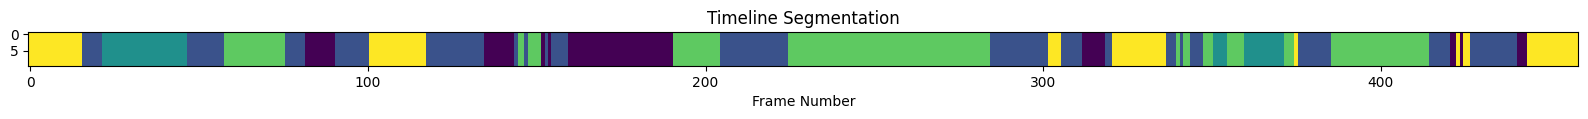

In [44]:
treal = test_pred.argmax(axis=1).tolist()
plt.figure(figsize=(20,20))
plt.imshow(np.tile(treal, (10, 1)))
plt.xlabel('Frame Number')
plt.title('Timeline Segmentation')
plt.show()

И полученные метрики. Обращаем внимание на низкую метрику для класса "кухня". Так получается потому, что зачастую на ранних стадиях строительство очень легко перепутать жилую комнату и кухня. Там ещё нет опознавательных объектов таких как кухонный шкаф или раковина. Кухню было трудно определить даже разметчику, естественному интеллекту.

In [45]:
print(class_names)
print(classification_report(treal, tpred))

['bathroom' 'corridor' 'kitchen' 'livingroom' 'mop' 'nan']
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        64
           1       0.82      0.89      0.85       141
           2       0.50      0.56      0.53        41
           3       0.84      0.76      0.80       141
           4       0.95      0.79      0.86        72

    accuracy                           0.82       459
   macro avg       0.80      0.79      0.79       459
weighted avg       0.82      0.82      0.82       459

